# Intraday Strategy, Part 2: Model Training & Signal Evaluation

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and use the features engineered in the last notebook to train gradient boosting model that predicts the returns for the NASDAQ100 stocks over the next 1-minute bar. 

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact. This does certainly not reflect market reality, and is rather due to the challenges of simulating a trading strategy at this much higher intraday frequency in a realistic manner using open-source tools.

Note also that this section has slightly changed from the version published in the book to permit replication using the Algoseek data sample.

In [26]:
%sudo apt install cmake
%pip install "lightgbm==3.3.5" --no-binary lightgbm --config-setting=cmake.define.USE_CUDA=ON 
%pip install tables


Usage:   
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] [-e] <vcs project url> ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] [-e] <local project path> ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] <archive url/path> ...

no such option: --install-option
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# https://docs.cupy.dev/en/stable/install.html#installing-cupy
%pip install cupy-cuda12x

In [1]:
%load_ext cython

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import sys, os
from pathlib import Path
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [5]:
# where we stored the features engineered in the previous notebook
data_store = '../data/nasdaq100/algoseek.h5'

In [6]:
# where we'll store the model results
result_store = 'results/intra_day.h5'

In [7]:
# here we save the trained models
model_path = Path('models/intraday')
if not model_path.exists():
    model_path.mkdir(parents=True)

## Load Model Data

In [8]:
data = pd.read_hdf(data_store, 'model_data')

In [9]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 22 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   minute          30875649 non-null  int64  
 1   ret1min         30612848 non-null  float64
 2   ret2min         30302846 non-null  float64
 3   ret3min         30220887 non-null  float64
 4   ret4min         30141503 non-null  float64
 5   ret5min         30063236 non-null  float64
 6   ret6min         29983969 non-null  float64
 7   ret7min         29903822 non-null  float64
 8   ret8min         29824607 non-null  float64
 9   ret9min         29745431 non-null  float64
 10  ret10min        29666821 non-null  float64
 11  fwd1min         30875649 non-null  float64
 12  rup             30083777 non-null  float64
 13  rdown           30083777 non-null  float64
 14  BOP             30612848 non-null  flo

In [10]:
data.sample(frac=.1).describe(percentiles=np.arange(.1, 1, .1))

,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,...,rup,rdown,BOP,CCI,MFI,STOCHRSI,slowd,slowk,NATR,trades_bid_ask
count,3.087565e+06,3.061362e+06,3.030188e+06,3.022019e+06,3.014197e+06,3.006300e+06,2.998519e+06,2.990312e+06,2.982506e+06,2.974622e+06,...,3.008589e+06,3.008589e+06,3.061362e+06,2.851899e+06,3.087384e+06,3.087191e+06,3.087349e+06,3.087349e+06,3.087384e+06,3.008589e+06
mean,1.944889e+02,-1.887610e-06,-8.065035e-07,-3.297842e-07,-4.814377e-07,6.583596e-07,1.191438e-06,1.954482e-06,2.060055e-06,3.576109e-06,...,5.227384e-01,5.130955e-01,-1.655015e-03,3.004653e-01,4.996978e+01,5.001287e+01,5.029402e+01,5.029088e+01,9.570635e-02,-3.983051e-02
std,1.127687e+02,8.402842e-04,1.137302e-03,1.364995e-03,1.549582e-03,1.711209e-03,1.856188e-03,1.991086e-03,2.108870e-03,2.230834e-03,...,2.346806e+01,1.366348e+01,6.262360e-01,1.089129e+02,1.968310e+01,3.549217e+01,2.770684e+01,2.860364e+01,7.491701e-02,3.371447e+01
min,0.000000e+00,-1.065409e-01,-1.357125e-01,-1.090065e-01,-1.209821e-01,-1.295314e-01,-1.674419e-01,-2.063684e-01,-2.114537e-01,-2.368217e-01,...,0.000000e+00,0.000000e+00,-1.000000e+00,-4.666667e+02,-1.116565e-06,0.000000e+00,-5.626709e-12,-5.082749e-12,1.457662e-07,-3.749900e+04
10%,3.800000e+01,-7.465472e-04,-1.046987e-03,-1.267427e-03,-1.452855e-03,-1.611665e-03,-1.758352e-03,-1.893561e-03,-2.022180e-03,-2.134069e-03,...,0.000000e+00,0.000000e+00,-9.000000e-01,-1.376849e+02,2.396122e+01,0.000000e+00,1.251537e+01,1.125000e+01,4.014872e-02,-7.305315e-01
20%,7.700000e+01,-4.079413e-04,-5.921540e-04,-7.198604e-04,-8.276898e-04,-9.196516e-04,-1.001447e-03,-1.078255e-03,-1.149260e-03,-1.214834e-03,...,9.671180e-02,9.907250e-02,-6.610169e-01,-9.985106e+01,3.242074e+01,9.822256e+00,2.097242e+01,2.000000e+01,4.869510e-02,-4.594821e-01
30%,1.160000e+02,-2.292001e-04,-3.363869e-04,-4.073320e-04,-4.719207e-04,-5.242006e-04,-5.726557e-04,-6.171570e-04,-6.579349e-04,-6.951686e-04,...,1.981744e-01,2.011529e-01,-4.457649e-01,-6.908105e+01,3.886708e+01,2.371294e+01,3.009259e+01,2.942601e+01,5.663596e-02,-2.769660e-01
40%,1.550000e+02,-9.559316e-05,-1.547269e-04,-1.857526e-04,-2.147592e-04,-2.382654e-04,-2.584811e-04,-2.798648e-04,-2.994012e-04,-3.157469e-04,...,2.863040e-01,2.913507e-01,-1.800000e-01,-3.692409e+01,4.454042e+01,3.692968e+01,4.000000e+01,3.966623e+01,6.516254e-02,-1.300594e-01
50%,1.940000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.708041e-01,3.756504e-01,0.000000e+00,7.582775e-01,4.992247e+01,5.005795e+01,5.037037e+01,5.017387e+01,7.511136e-02,0.000000e+00
60%,2.340000e+02,9.157509e-05,1.513008e-04,1.806358e-04,2.086811e-04,2.333086e-04,2.551020e-04,2.762813e-04,2.967183e-04,3.158873e-04,...,4.586026e-01,4.635415e-01,1.669449e-01,3.808214e+01,5.530285e+01,6.315001e+01,6.077778e+01,6.111111e+01,8.747754e-02,1.045131e-01


## Model Training

### Helper functions

In [11]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


In [12]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Categorical Variables

In [13]:
data['stock_id'] = pd.factorize(data.index.get_level_values('ticker'), sort=True)[0]

In [14]:
categoricals = ['stock_id']

### Custom Metric

In [2]:
import cupy
import cupyx.scipy.stats as cupy_stats

# This doesn't work because CuPy doesn't have stats.spearmanr, or most other scipy.stats functions.
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    # is_higher_better = True
    preds_gpu = cupy.array(preds)
    labels_gpu = cupy.array(train_data.get_label())
    return 'ic', cpstats.spearmanr(preds_gpu, labels_gpu)[0], True

cupy.cuda.runtime.getDeviceCount()

1

In [15]:
from scipy.stats import spearmanr


def ic_lgbm(preds: np.ndarray, train_data: np.ndarray):
    """Custom IC eval metric for lightgbm"""
    return 'ic', spearmanr(preds, train_data.get_label())[0], True # is_higher_better

In [45]:
%%cython


# Source from https://github.com/scipy/scipy/blob/main/scipy/stats/_mstats_basic.py
# Inline Cython because these functions aren't .pyx in SciPy.

import numpy as np
from numpy import ndarray
import numpy.ma as ma
from numpy.ma import masked, nomask
import math

import itertools
import warnings
from collections import namedtuple

from scipy._lib._util import _rename_parameter, _contains_nan
from scipy._lib._bunch import _make_tuple_bunch
import scipy.special as special
import scipy.stats._stats_py
import scipy.stats._stats_py as _stats_py


def _chk_asarray(a, axis):
    # Always returns a masked array, raveled for axis=None
    a = ma.asanyarray(a)
    if axis is None:
        a = ma.ravel(a)
        outaxis = 0
    else:
        outaxis = axis
    return a, outaxis


def _ttest_finish(df, t, alternative):
    """Common code between all 3 t-test functions."""
    # We use ``stdtr`` directly here to preserve masked arrays

    if alternative == 'less':
        pval = special._ufuncs.stdtr(df, t)
    elif alternative == 'greater':
        pval = special._ufuncs.stdtr(df, -t)
    elif alternative == 'two-sided':
        pval = special._ufuncs.stdtr(df, -np.abs(t))*2
    else:
        raise ValueError("alternative must be "
                         "'less', 'greater' or 'two-sided'")

    if t.ndim == 0:
        t = t[()]
    if pval.ndim == 0:
        pval = pval[()]

    return t, pval


def _find_repeats(arr):
    # This function assumes it may clobber its input.
    if len(arr) == 0:
        return np.array(0, np.float64), np.array(0, np.intp)

    # XXX This cast was previously needed for the Fortran implementation,
    # should we ditch it?
    arr = np.asarray(arr, np.float64).ravel()
    arr.sort()

    # Taken from NumPy 1.9's np.unique.
    change = np.concatenate(([True], arr[1:] != arr[:-1]))
    unique = arr[change]
    change_idx = np.concatenate(np.nonzero(change) + ([arr.size],))
    freq = np.diff(change_idx)
    atleast2 = freq > 1
    return unique[atleast2], freq[atleast2]


def find_repeats(arr):
    """Find repeats in arr and return a tuple (repeats, repeat_count).

    The input is cast to float64. Masked values are discarded.

    Parameters
    ----------
    arr : sequence
        Input array. The array is flattened if it is not 1D.

    Returns
    -------
    repeats : ndarray
        Array of repeated values.
    counts : ndarray
        Array of counts.

    Examples
    --------
    >>> from scipy.stats import mstats
    >>> mstats.find_repeats([2, 1, 2, 3, 2, 2, 5])
    (array([2.]), array([4]))

    In the above example, 2 repeats 4 times.

    >>> mstats.find_repeats([[10, 20, 1, 2], [5, 5, 4, 4]])
    (array([4., 5.]), array([2, 2]))

    In the above example, both 4 and 5 repeat 2 times.

    """
    # Make sure we get a copy. ma.compressed promises a "new array", but can
    # actually return a reference.
    compr = np.asarray(ma.compressed(arr), dtype=np.float64)
    try:
        need_copy = np.may_share_memory(compr, arr)
    except AttributeError:
        # numpy < 1.8.2 bug: np.may_share_memory([], []) raises,
        # while in numpy 1.8.2 and above it just (correctly) returns False.
        need_copy = False
    if need_copy:
        compr = compr.copy()
    return _find_repeats(compr)


def rankdata(data, axis=None, use_missing=False):
    """Returns the rank (also known as order statistics) of each data point
    along the given axis.

    If some values are tied, their rank is averaged.
    If some values are masked, their rank is set to 0 if use_missing is False,
    or set to the average rank of the unmasked values if use_missing is True.

    Parameters
    ----------
    data : sequence
        Input data. The data is transformed to a masked array
    axis : {None,int}, optional
        Axis along which to perform the ranking.
        If None, the array is first flattened. An exception is raised if
        the axis is specified for arrays with a dimension larger than 2
    use_missing : bool, optional
        Whether the masked values have a rank of 0 (False) or equal to the
        average rank of the unmasked values (True).

    """
    def _rank1d(data, use_missing=False):
        n = data.count()
        rk = np.empty(data.size, dtype=float)
        idx = data.argsort()
        rk[idx[:n]] = np.arange(1,n+1)

        if use_missing:
            rk[idx[n:]] = (n+1)/2.
        else:
            rk[idx[n:]] = 0

        repeats = find_repeats(data.copy())
        for r in repeats[0]:
            condition = (data == r).filled(False)
            rk[condition] = rk[condition].mean()
        return rk

    data = ma.array(data, copy=False)
    if axis is None:
        if data.ndim > 1:
            return _rank1d(data.ravel(), use_missing).reshape(data.shape)
        else:
            return _rank1d(data, use_missing)
    else:
        return ma.apply_along_axis(_rank1d,axis,data,use_missing).view(ndarray)


    ModeResult = namedtuple('ModeResult', ('mode', 'count'))



def spearmanr(x, y=None, use_ties=True, axis=None, nan_policy='propagate',
              alternative='two-sided'):
    """
    Calculates a Spearman rank-order correlation coefficient and the p-value
    to test for non-correlation.

    The Spearman correlation is a nonparametric measure of the linear
    relationship between two datasets. Unlike the Pearson correlation, the
    Spearman correlation does not assume that both datasets are normally
    distributed. Like other correlation coefficients, this one varies
    between -1 and +1 with 0 implying no correlation. Correlations of -1 or
    +1 imply a monotonic relationship. Positive correlations imply that
    as `x` increases, so does `y`. Negative correlations imply that as `x`
    increases, `y` decreases.

    Missing values are discarded pair-wise: if a value is missing in `x`, the
    corresponding value in `y` is masked.

    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Spearman correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.

    Parameters
    ----------
    x, y : 1D or 2D array_like, y is optional
        One or two 1-D or 2-D arrays containing multiple variables and
        observations. When these are 1-D, each represents a vector of
        observations of a single variable. For the behavior in the 2-D case,
        see under ``axis``, below.
    use_ties : bool, optional
        DO NOT USE.  Does not do anything, keyword is only left in place for
        backwards compatibility reasons.
    axis : int or None, optional
        If axis=0 (default), then each column represents a variable, with
        observations in the rows. If axis=1, the relationship is transposed:
        each row represents a variable, while the columns contain observations.
        If axis=None, then both arrays will be raveled.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan. 'propagate' returns nan,
        'raise' throws an error, 'omit' performs the calculations ignoring nan
        values. Default is 'propagate'.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        The following options are available:

        * 'two-sided': the correlation is nonzero
        * 'less': the correlation is negative (less than zero)
        * 'greater':  the correlation is positive (greater than zero)

        .. versionadded:: 1.7.0

    Returns
    -------
    res : SignificanceResult
        An object containing attributes:

        statistic : float or ndarray (2-D square)
            Spearman correlation matrix or correlation coefficient (if only 2
            variables are given as parameters). Correlation matrix is square
            with length equal to total number of variables (columns or rows) in
            ``a`` and ``b`` combined.
        pvalue : float
            The p-value for a hypothesis test whose null hypothesis
            is that two sets of data are linearly uncorrelated. See
            `alternative` above for alternative hypotheses. `pvalue` has the
            same shape as `statistic`.

    References
    ----------
    [CRCProbStat2000] section 14.7

    """
    if not use_ties:
        raise ValueError("`use_ties=False` is not supported in SciPy >= 1.2.0")

    # Always returns a masked array, raveled if axis=None
    x, axisout = _chk_asarray(x, axis)
    if y is not None:
        # Deal only with 2-D `x` case.
        y, _ = _chk_asarray(y, axis)
        if axisout == 0:
            x = ma.column_stack((x, y))
        else:
            x = ma.vstack((x, y))

    if axisout == 1:
        # To simplify the code that follow (always use `n_obs, n_vars` shape)
        x = x.T

    if nan_policy == 'omit':
        x = ma.masked_invalid(x)

    def _spearmanr_2cols(x):
        # Mask the same observations for all variables, and then drop those
        # observations (can't leave them masked, rankdata is weird).
        x = ma.mask_rowcols(x, axis=0)
        x = x[~x.mask.any(axis=1), :]

        # If either column is entirely NaN or Inf
        if not np.any(x.data):
            res = scipy.stats._stats_py.SignificanceResult(np.nan, np.nan)
            res.correlation = np.nan
            return res

        m = ma.getmask(x)
        n_obs = x.shape[0]
        dof = n_obs - 2 - int(m.sum(axis=0)[0])
        if dof < 0:
            raise ValueError("The input must have at least 3 entries!")

        # Gets the ranks and rank differences
        x_ranked = rankdata(x, axis=0)
        rs = ma.corrcoef(x_ranked, rowvar=False).data

        # rs can have elements equal to 1, so avoid zero division warnings
        with np.errstate(divide='ignore'):
            # clip the small negative values possibly caused by rounding
            # errors before taking the square root
            t = rs * np.sqrt((dof / ((rs+1.0) * (1.0-rs))).clip(0))

        t, prob = _ttest_finish(dof, t, alternative)

        # For backwards compatibility, return scalars when comparing 2 columns
        if rs.shape == (2, 2):
            res = scipy.stats._stats_py.SignificanceResult(rs[1, 0],
                                                           prob[1, 0])
            res.correlation = rs[1, 0]
            return res
        else:
            res = scipy.stats._stats_py.SignificanceResult(rs, prob)
            res.correlation = rs
            return res

    # Need to do this per pair of variables, otherwise the dropped observations
    # in a third column mess up the result for a pair.
    n_vars = x.shape[1]
    if n_vars == 2:
        return _spearmanr_2cols(x)
    else:
        rs = np.ones((n_vars, n_vars), dtype=float)
        prob = np.zeros((n_vars, n_vars), dtype=float)
        for var1 in range(n_vars - 1):
            for var2 in range(var1+1, n_vars):
                result = _spearmanr_2cols(x[:, [var1, var2]])
                rs[var1, var2] = result.correlation
                rs[var2, var1] = result.correlation
                prob[var1, var2] = result.pvalue
                prob[var2, var1] = result.pvalue

        res = scipy.stats._stats_py.SignificanceResult(rs, prob)
        res.correlation = rs
        return res


def ic_lgbm(preds: np.narray, train_data: np.narray):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Cross-validation setup

In [16]:
DAY = 390   # number of minute bars in a trading day of 6.5 hrs (9:30 - 15:59)
MONTH = 21  # trading days

In [17]:
def get_cv(n_splits=23):
    return MultipleTimeSeriesCV(n_splits=n_splits,
                                lookahead=1,
                                test_period_length=MONTH * DAY,       # test for 1 month
                                train_period_length=12 * MONTH * DAY,  # train for 1 year
                                date_idx='date_time')

Show train/validation periods:

In [18]:
for i, (train_idx, test_idx) in enumerate(get_cv().split(X=data)):
    train_dates = data.iloc[train_idx].index.unique('date_time')
    test_dates = data.iloc[test_idx].index.unique('date_time')
    print(train_dates.min(), train_dates.max(), test_dates.min(), test_dates.max())

2016-11-29 15:59:00 2017-11-29 15:59:00 2017-11-30 09:30:00 2017-12-29 15:59:00
2016-10-28 15:47:00 2017-10-30 15:58:00 2017-10-30 15:59:00 2017-11-29 15:59:00
2016-09-29 15:47:00 2017-09-29 15:58:00 2017-09-29 15:59:00 2017-10-30 15:58:00
2016-08-30 15:47:00 2017-08-30 15:58:00 2017-08-30 15:59:00 2017-09-29 15:58:00
2016-08-01 15:47:00 2017-08-01 15:58:00 2017-08-01 15:59:00 2017-08-30 15:58:00
2016-06-30 15:47:00 2017-06-30 15:58:00 2017-06-30 15:59:00 2017-08-01 15:58:00
2016-06-01 15:47:00 2017-06-01 15:58:00 2017-06-01 15:59:00 2017-06-30 15:58:00
2016-05-02 15:47:00 2017-05-02 15:58:00 2017-05-02 15:59:00 2017-06-01 15:58:00
2016-04-01 15:47:00 2017-03-31 15:58:00 2017-03-31 15:59:00 2017-05-02 15:58:00
2016-03-02 15:47:00 2017-03-02 15:58:00 2017-03-02 15:59:00 2017-03-31 15:58:00
2016-02-01 15:47:00 2017-01-31 15:58:00 2017-01-31 15:59:00 2017-03-02 15:58:00
2015-12-30 15:47:00 2016-12-29 15:58:00 2016-12-29 15:59:00 2017-01-31 15:58:00
2015-11-30 15:23:00 2016-11-29 15:58:00 

### Train model

In [19]:
label = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(label).tolist()
label = label[0]

In [20]:
params = dict(objective='regression',
              metric=['rmse'],
              device='gpu',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [21]:
params = dict(objective='regression',
              metric=['rmse'],
              device='cpu',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [21]:
num_boost_round = 250

In [22]:
cv = get_cv(n_splits=23) # we have enough data for 23 different test periods

In [23]:
def get_scores(result):
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

The following model-training loop will take more than 10 hours to run and also consumes substantial memory. If you run into resource constraints, you can modify the code, e.g., by:
1. Only loading data required for one iteration.
2. Shortening the training period to require less than one year.

You can also speed up the process by using fewer `n_splits`, which implies longer test periods.

In [24]:
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
    # create lgb train set
    train_set = data.iloc[train_idx, :]
    lgb_train = lgb.Dataset(data=train_set.drop(label, axis=1),
                            label=train_set[label],
                            categorical_feature=categoricals)
    
    # create lgb test set
    test_set = data.iloc[test_idx, :]
    lgb_test = lgb.Dataset(data=test_set.drop(label, axis=1),
                           label=test_set[label],
                           categorical_feature=categoricals, 
                           reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.record_evaluation(evals_result)])
    model.save_model((model_path / f'{fold:02}.txt').as_posix())
    
    # get train/valid ic scores
    scores = get_scores(evals_result)
    scores.to_hdf(result_store, f'ic/{fold:02}')
    
    # get feature importance
    fi = get_fi(model)
    fi.to_hdf(result_store, f'fi/{fold:02}')
    
    # generate validation predictions
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, [label]]
    y_test['pred'] = model.predict(X_test)
    y_test.to_hdf(result_store, f'predictions/{fold:02}')
    
    # compute average IC per minute
    by_minute = y_test.groupby(test_set.index.get_level_values('date_time'))
    daily_ic = by_minute.apply(lambda x: spearmanr(x[label], x.pred)[0]).mean()
    print(f'\nFold: {fold:02} | {format_time(time()-start)} | IC per minute: {daily_ic:.2%}\n')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	training's rmse: 0.000695745	training's ic: 0.0428019	valid_1's rmse: 0.000816056	valid_1's ic: 0.0558975

Fold: 01 | 00:05:24 | IC per minute: 5.64%

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	training's rmse: 0.000698866	training's ic: 0.0456962	valid_1's rmse: 0.000847735	valid_1's ic: 0.0438048

Fold: 02 | 00:13:01 | IC per minute: 4.29%

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	training's rmse: 0.000697442	training's ic: 0.0451649	valid_1's rmse: 0.000706078	valid_1's ic: 0.041496

Fold: 03 | 00:20:41 | IC per minute: 4.43%

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	training's rmse: 0.000699919	training's ic: 0.0474068	valid_1's rmse: 0.000669584	valid_1's ic: 0.035081

Fold: 04 | 00:29:57 | IC per minute

In [25]:
start

1729225013.320666

## Signal Evaluation

In [253]:
with pd.HDFStore(result_store) as store:
    pred_keys = [k[1:] for k in store.keys() if k[1:].startswith('pred')]
    cv_predictions = pd.concat([store[k] for k in pred_keys]).sort_index()

In [254]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19648064 entries, ('AAL', Timestamp('2016-02-01 15:47:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 2 columns):
 #   Column   Non-Null Count     Dtype  
---  ------   --------------     -----  
 0   fwd1min  19648064 non-null  float64
 1   pred     19648064 non-null  float64
dtypes: float64(2)
memory usage: 422.6+ MB


In [255]:
time_stamp = cv_predictions.index.get_level_values('date_time')
dates = sorted(np.unique(time_stamp.date))

We have out-of-sample predictions for 484 days from February 2016 through December 2017:

In [256]:
print(f'# Days: {len(dates)} | First: {dates[0]} | Last: {dates[-1]}')

# Days: 484 | First: 2016-02-01 | Last: 2017-12-29


We only use minutes with at least 100 predictions:

In [257]:
n = cv_predictions.groupby('date_time').size()

There are ~700 periods, equivalent to a bit over a single trading day (0.67% of all periods in the sample), with fewer than 100 predictions over the 23 test months:

In [258]:
n

date_time
2016-02-01 15:47:00    106
2016-02-01 15:48:00    106
2016-02-01 15:49:00    106
2016-02-01 15:50:00    106
2016-02-01 15:51:00    106
                      ... 
2017-12-29 15:55:00    104
2017-12-29 15:56:00    104
2017-12-29 15:57:00    104
2017-12-29 15:58:00    104
2017-12-29 15:59:00    104
Length: 188370, dtype: int64

In [259]:
incomplete_minutes = n[n<100].index
incomplete_minutes

DatetimeIndex(['2016-02-05 09:31:00', '2016-02-22 12:53:00',
               '2016-02-23 12:07:00', '2016-03-02 12:39:00',
               '2016-03-14 12:05:00', '2016-03-23 11:38:00',
               '2016-03-24 13:14:00', '2016-03-28 13:06:00',
               '2016-03-28 13:37:00', '2016-04-01 13:36:00',
               ...
               '2017-12-29 13:14:00', '2017-12-29 13:18:00',
               '2017-12-29 13:20:00', '2017-12-29 13:30:00',
               '2017-12-29 13:32:00', '2017-12-29 13:47:00',
               '2017-12-29 13:48:00', '2017-12-29 14:20:00',
               '2017-12-29 14:24:00', '2017-12-29 14:32:00'],
              dtype='datetime64[ns]', name='date_time', length=1255, freq=None)

In [260]:
print(f'{len(incomplete_minutes)} ({len(incomplete_minutes)/len(n):.2%})')

1255 (0.67%)


In [261]:
cv_predictions = cv_predictions[~time_stamp.isin(incomplete_minutes)]
time_stamp = cv_predictions.index.get_level_values('date_time')

In [262]:
# We also need at least 10 different pred values in order to bin them.

In [263]:
nv = cv_predictions["pred"].groupby('date_time').nunique()
nv

date_time
2016-02-01 15:47:00     78
2016-02-01 15:48:00     75
2016-02-01 15:49:00     65
2016-02-01 15:50:00     83
2016-02-01 15:51:00     61
                      ... 
2017-12-29 15:55:00    104
2017-12-29 15:56:00    104
2017-12-29 15:57:00    104
2017-12-29 15:58:00    104
2017-12-29 15:59:00    104
Name: pred, Length: 187115, dtype: int64

In [264]:
incomplete_minutesv = nv[nv <= 90].index
incomplete_minutesv

DatetimeIndex(['2016-02-01 15:47:00', '2016-02-01 15:48:00',
               '2016-02-01 15:49:00', '2016-02-01 15:50:00',
               '2016-02-01 15:51:00', '2016-02-01 15:52:00',
               '2016-02-01 15:53:00', '2016-02-01 15:54:00',
               '2016-02-01 15:55:00', '2016-02-01 15:56:00',
               ...
               '2016-08-30 14:35:00', '2016-08-30 14:57:00',
               '2016-08-30 15:02:00', '2016-08-30 15:21:00',
               '2016-08-31 14:05:00', '2016-09-01 13:20:00',
               '2016-09-01 14:46:00', '2016-09-14 14:42:00',
               '2016-09-16 12:40:00', '2016-09-20 14:56:00'],
              dtype='datetime64[ns]', name='date_time', length=20659, freq=None)

In [265]:
print(f'{len(incomplete_minutesv)} ({len(incomplete_minutesv)/len(nv):.2%})')

20659 (11.04%)


In [266]:
cv_predictions = cv_predictions[~time_stamp.isin(incomplete_minutesv)]

In [267]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17377280 entries, ('AAL', Timestamp('2016-02-02 09:31:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 2 columns):
 #   Column   Non-Null Count     Dtype  
---  ------   --------------     -----  
 0   fwd1min  17377280 non-null  float64
 1   pred     17377280 non-null  float64
dtypes: float64(2)
memory usage: 374.9+ MB


### Information Coefficient

#### Across all periods

In [268]:
ic = spearmanr(cv_predictions.fwd1min, cv_predictions.pred)[0]

#### By minute

We are making new predictions every minute, so it makes sense to look at the average performance across all short-term forecasts:

In [269]:
minutes = cv_predictions.index.get_level_values('date_time')
by_minute = cv_predictions.groupby(minutes)

In [270]:
ic_by_minute = by_minute.apply(lambda x: spearmanr(x.fwd1min, x.pred)[0])

minute_ic_mean = ic_by_minute.mean()
minute_ic_median = ic_by_minute.median()

print(f'\nAll periods: {ic:6.2%} | By Minute: {minute_ic_mean: 6.2%} (Median: {minute_ic_median: 6.2%})')


All periods:  2.95% | By Minute:  3.15% (Median:  3.18%)


Plotted as a five-day rolling average, we see that the IC was mostly below the out-of-sample period mean, and increased during the last quarter of 2017 (as reflected in the validation results we observed while training the model).

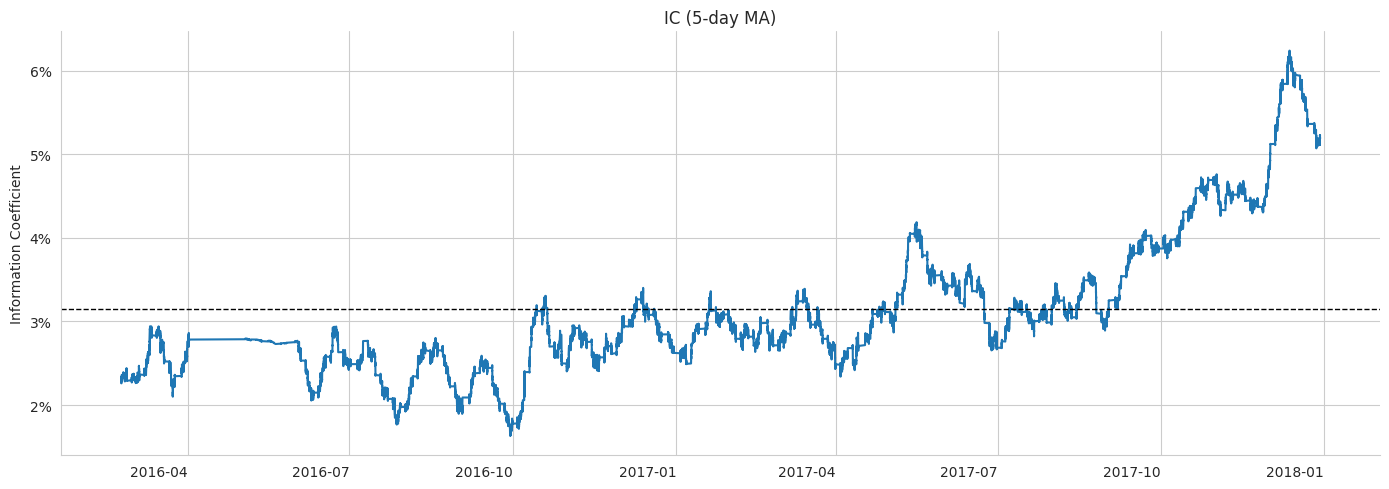

In [271]:
ax = ic_by_minute.rolling(5*650).mean().plot(figsize=(14, 5), title='IC (5-day MA)', rot=0)
ax.axhline(minute_ic_mean, ls='--', lw=1, c='k')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Information Coefficient')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Vectorized backtest of a naive strategey: financial performance by signal quantile

Alphalens does not work with minute-data, so we need to compute our own signal performance measures.

Unfortunately, Zipline's Pipeline also doesn't work for minute-data and Backtrader takes a very long time with such a large dataset. Hence, instead of an event-driven backtest of entry/exit rules as in previous examples, we can only create a rough sketch of the financial performance of a naive trading strategy driven by the model's predictions using vectorized backtesting (see Chapter 8 on the [ML4T workflow](../08_ml4t_workflow'). As we will see below, this does not produce particularly helpful results.

This naive strategy invests in equal-weighted portfolios of the stocks in each decile under the following assumptions (mentioned at the beginning of this notebook: 
1. Based on the predictions using inputs from the current and previous bars, we can enter positions at the first trade price in the following minute bar
2. We exit all positions at the last price in that following minute bar
3. There are no trading cost or market impact (slippage) of our trades (but we can check how sensitive the results would be).

#### Average returns by minute bar and signal quantile 

To this end, we compute the quintiles and deciles of the model's `fwd1min` predictions for each minute:

In [272]:
cv_predictions

fwd1min      pred
ticker date_time                              
AAL    2016-02-02 09:31:00 -0.006968  0.000009
       2016-02-02 09:32:00 -0.001388  0.000031
       2016-02-02 09:33:00  0.001431 -0.000001
       2016-02-02 09:34:00 -0.000779  0.000610
       2016-02-02 09:35:00 -0.000778  0.000558
...                              ...       ...
YHOO   2017-06-16 15:55:00 -0.000663  0.000010
       2017-06-16 15:56:00  0.001138 -0.000020
       2017-06-16 15:57:00  0.001894  0.000014
       2017-06-16 15:58:00 -0.006051 -0.000007
       2017-06-16 15:59:00  0.001519  0.000160

[17377280 rows x 2 columns]

In [273]:
by_minute = cv_predictions.groupby(minutes, group_keys=False)

In [274]:
nunique_by_minute = cv_predictions['pred'].groupby(minutes, group_keys=False).nunique()
nunique_by_minute[nunique_by_minute <= 90]

Series([], Name: pred, dtype: int64)

In [275]:
labels = list(range(1, 6))
cv_predictions['quintile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=len(labels), precision=np.inf, labels=labels))

In [276]:
labels = list(range(1, 11))
cv_predictions['decile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=len(labels), labels=labels).astype(int))

In [277]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17377280 entries, ('AAL', Timestamp('2016-02-02 09:31:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 4 columns):
 #   Column    Non-Null Count     Dtype   
---  ------    --------------     -----   
 0   fwd1min   17377280 non-null  float64 
 1   pred      17377280 non-null  float64 
 2   quintile  17377280 non-null  category
 3   decile    17377280 non-null  int64   
dtypes: category(1), float64(2), int64(1)
memory usage: 524.1+ MB


In [278]:
cv_predictions

fwd1min      pred quintile  decile
ticker date_time                                               
AAL    2016-02-02 09:31:00 -0.006968  0.000009        3       5
       2016-02-02 09:32:00 -0.001388  0.000031        4       8
       2016-02-02 09:33:00  0.001431 -0.000001        3       6
       2016-02-02 09:34:00 -0.000779  0.000610        5      10
       2016-02-02 09:35:00 -0.000778  0.000558        5      10
...                              ...       ...      ...     ...
YHOO   2017-06-16 15:55:00 -0.000663  0.000010        5       9
       2017-06-16 15:56:00  0.001138 -0.000020        1       1
       2017-06-16 15:57:00  0.001894  0.000014        5      10
       2017-06-16 15:58:00 -0.006051 -0.000007        2       3
       2017-06-16 15:59:00  0.001519  0.000160        5      10

[17377280 rows x 4 columns]

#### Descriptive statistics of intraday returns by quintile and decile of model predictions

Next, we compute the average one-minute returns for each quintile / decile and minute.

In [279]:
def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
    by_quantile = cv_predictions.reset_index().groupby(['date_time', quantile])
    return by_quantile.fwd1min.mean().unstack(quantile).sort_index()

In [280]:
intraday_returns = {'quintile': compute_intraday_returns_by_quantile(cv_predictions),
                    'decile': compute_intraday_returns_by_quantile(cv_predictions, quantile='decile')}

In [281]:
def summarize_intraday_returns(returns):
    summary = returns.describe(deciles)
    return pd.concat([summary.iloc[:1].applymap(lambda x: f'{x:,.0f}'),
                      summary.iloc[1:].applymap(lambda x: f'{x:.4%}')])

The returns per minute, averaged over the 23-months period, increase by quintile/decile and range from -.3 (-.4) to .27 (.37) basis points for the bottom and top quintile (decile), respectively. While this aligns with the finding of a weakly positive rank correlation coefficient, it also suggests that such small gains are unlikely to survive the impact of trading costs.

In [282]:
summary = summarize_intraday_returns(intraday_returns['quintile'])
summary

quintile,1,2,3,4,5
count,"166,456","166,456","166,456","166,456","166,456"
mean,-0.0029%,-0.0011%,-0.0002%,0.0006%,0.0026%
std,0.0353%,0.0299%,0.0294%,0.0301%,0.0356%
min,-0.6427%,-0.4948%,-0.4994%,-0.5597%,-0.6089%
10%,-0.0378%,-0.0315%,-0.0299%,-0.0292%,-0.0309%
20%,-0.0223%,-0.0184%,-0.0174%,-0.0166%,-0.0169%
30%,-0.0139%,-0.0111%,-0.0102%,-0.0095%,-0.0090%
40%,-0.0077%,-0.0056%,-0.0048%,-0.0040%,-0.0031%
50%,-0.0022%,-0.0008%,-0.0000%,0.0007%,0.0022%
60%,0.0031%,0.0040%,0.0048%,0.0054%,0.0076%


In [283]:
summary = summarize_intraday_returns(intraday_returns['decile'])
summary

decile,1,2,3,4,5,6,7,8,9,10
count,"166,456","166,456","166,456","166,456","166,456","166,456","166,456","166,456","166,456","166,456"
mean,-0.0039%,-0.0019%,-0.0014%,-0.0009%,-0.0004%,-0.0000%,0.0004%,0.0009%,0.0016%,0.0036%
std,0.0430%,0.0358%,0.0332%,0.0326%,0.0321%,0.0325%,0.0327%,0.0334%,0.0353%,0.0435%
min,-0.7286%,-0.6249%,-0.5661%,-0.9075%,-0.9472%,-0.9272%,-0.5227%,-0.6282%,-0.6258%,-0.8837%
10%,-0.0465%,-0.0375%,-0.0354%,-0.0343%,-0.0332%,-0.0330%,-0.0325%,-0.0323%,-0.0328%,-0.0370%
20%,-0.0275%,-0.0224%,-0.0209%,-0.0202%,-0.0195%,-0.0193%,-0.0189%,-0.0186%,-0.0186%,-0.0201%
30%,-0.0173%,-0.0137%,-0.0128%,-0.0121%,-0.0117%,-0.0113%,-0.0109%,-0.0106%,-0.0104%,-0.0108%
40%,-0.0097%,-0.0072%,-0.0065%,-0.0060%,-0.0056%,-0.0053%,-0.0049%,-0.0045%,-0.0042%,-0.0035%
50%,-0.0030%,-0.0014%,-0.0010%,-0.0005%,-0.0002%,0.0001%,0.0005%,0.0009%,0.0014%,0.0028%
60%,0.0037%,0.0043%,0.0045%,0.0049%,0.0052%,0.0055%,0.0058%,0.0063%,0.0070%,0.0094%


#### Cumulative Performance by Quantile

To simulate the performance of our naive strategy that trades all available stocks every minute, we simply assume that we can reinvest (including potential gains/losses) every minute. To check for the sensitivity with respect for trading cost, we can assume they are a constant number (fraction) of basis points, and subtract this number from the minute-bar returns.

In [284]:
def plot_cumulative_performance(returns, quantile='quintile', trading_costs_bp=0):
    """Plot average return by quantile (in bp) as well as cumulative return, 
        both net of trading costs (provided as basis points; 1bp = 0.01%) 
    """

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

    sns.barplot(y='fwd1min', x=quantile,
                data=returns[quantile].mul(10000).sub(trading_costs_bp).stack().to_frame(
                    'fwd1min').reset_index(),
                ax=axes[0])
    axes[0].set_title(f'Avg. 1-min Return by Signal {quantile.capitalize()}')
    axes[0].set_ylabel('Return (bps)')
    axes[0].set_xlabel(quantile.capitalize())

    title = f'Cumulative Return by Signal {quantile.capitalize()}'
    (returns[quantile].sort_index().add(1).sub(trading_costs_bp/10000).cumprod().sub(1)
     .plot(ax=axes[1], title=title))

    axes[1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Return')
    fig.suptitle(f'Average and Cumulative Performance (Net of Trading Cost: {trading_costs_bp:.2f}bp)')

    sns.despine()
    fig.tight_layout()

Without trading costs, the compounding of even fairly small gains leads to extremely large cumulative profits for the top quantile. However, these disappear as soon as we allow for minuscule trading costs that reduce the average quantile return close to zero.

##### Without trading costs

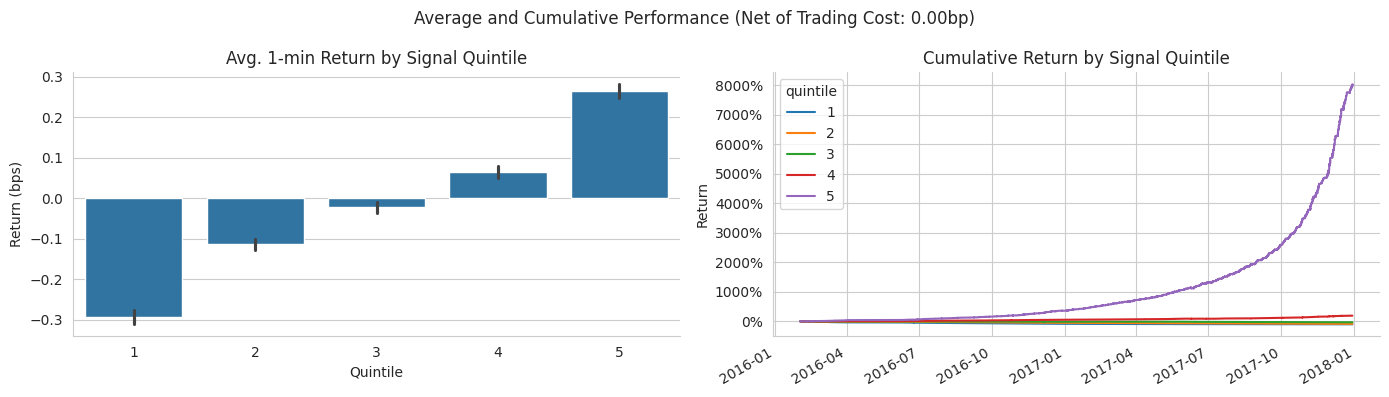

In [285]:
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=0)

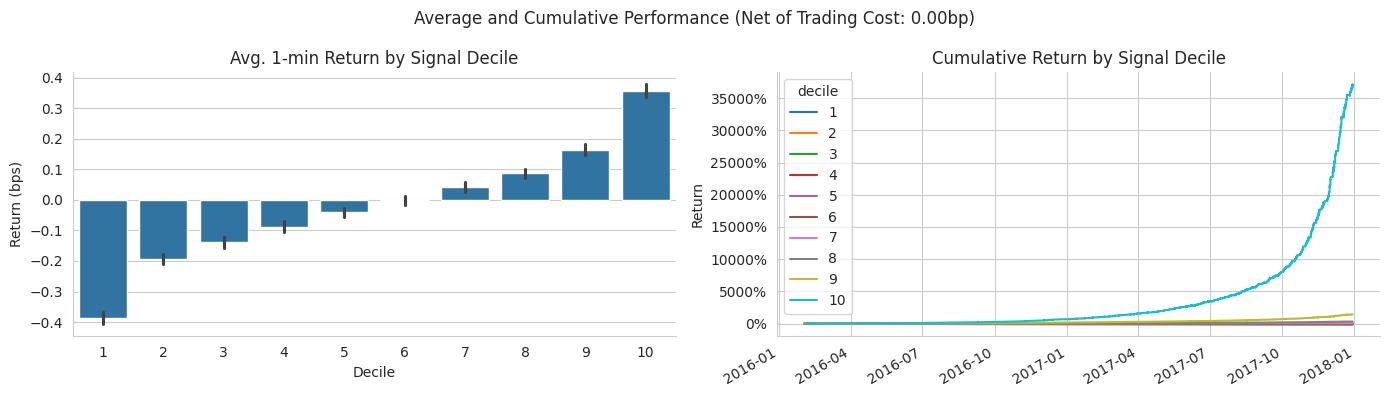

In [286]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=0)

##### With extremely low trading costs

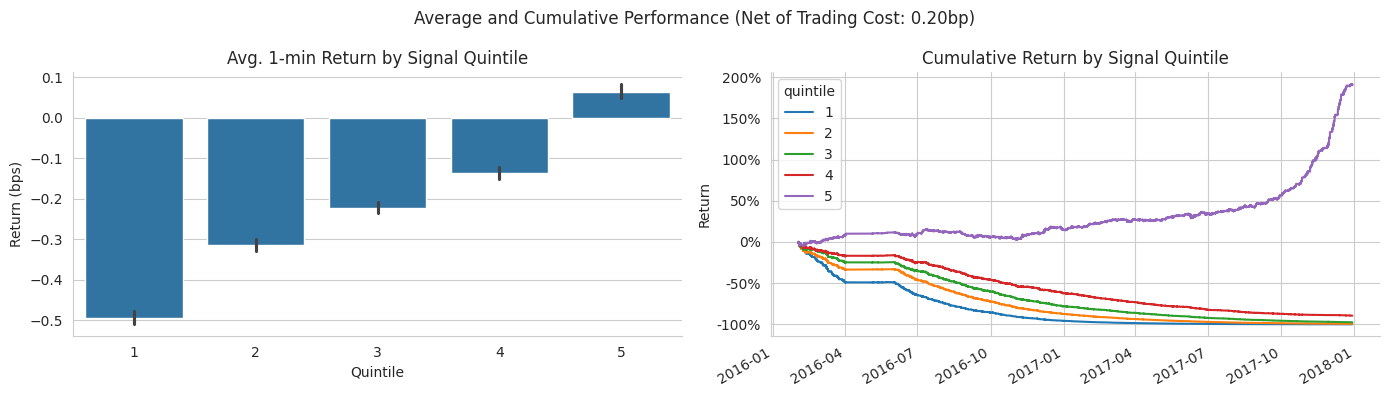

In [287]:
# assuming costs of a fraction of a basis point, close to the average return of the top quantile
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=.2)

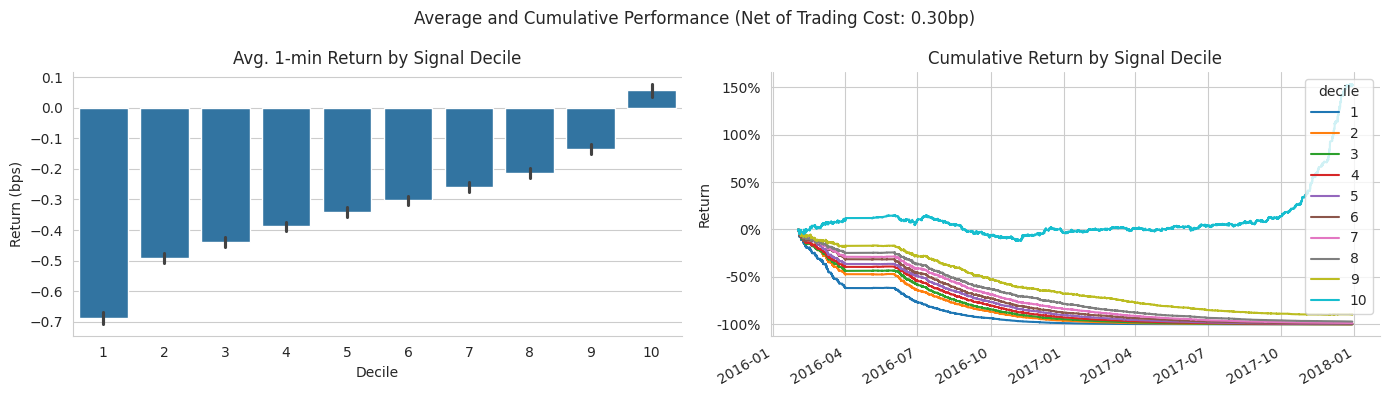

In [288]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=.3)

### Feature Importance

We'll take a quick look at the features that most contributed to improving the IC across the 23 folds:

In [289]:
with pd.HDFStore(result_store) as store:
    fi_keys = [k[1:] for k in store.keys() if k[1:].startswith('fi')]
    fi = pd.concat([store[k].to_frame(i) for i, k in enumerate(fi_keys, 1)], axis=1)

The top features from a conventional feature importance perspective are the ticker, followed by NATR, minute of the day, latest 1m return and the CCI:

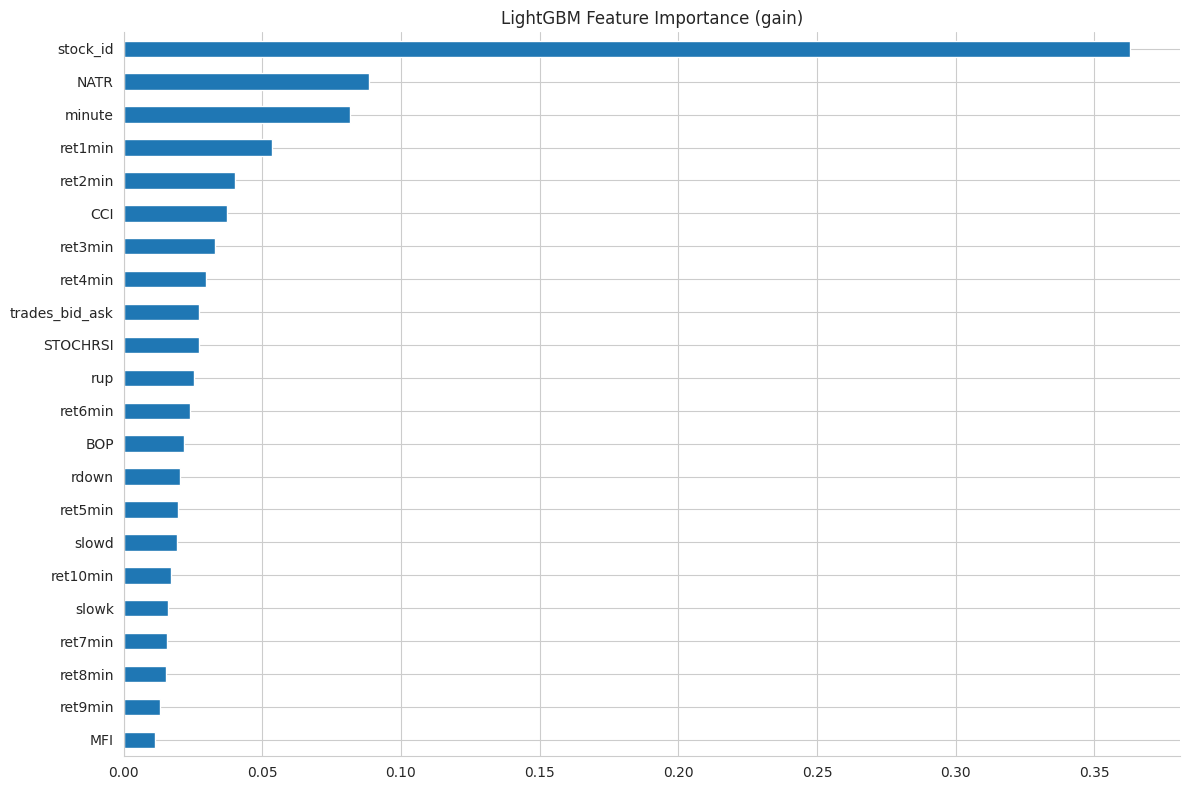

In [290]:
fi.mean(1).nsmallest(25).plot.barh(figsize=(12, 8), title='LightGBM Feature Importance (gain)')
sns.despine()
plt.tight_layout();

Explore with greater accuracy and in more detail how feature values affect predictions using SHAP values as demonstrated in various other notebooks in this Chapter and the appendix!

## Conclusion

We have seen that a relatively simple gradient boosting model is able to achieve fairly consistent predictive performance that is significantly better than a random guess even on a very short horizon. 

However, the resulting economic gains of our naive strategy of frequently buying/(short-)selling the top/bottome quantiles are too small to overcome the inevitable transaction costs. On the one hand, this demonstrates the challenges of extracting value from a predictive signal. On the other hand, it shows that we need a more sophisticated backtesting platform so that we can even begin to design and evaluate a more sophisticated strategy that requires far fewer trades to exploit the signal in our ML predictions. 

In addition, we would also want to work on improving the model by adding more informative feature, e.g. based on the quote/trade info contained in the Algoseek data, or by fine-tuning our model architecture and hyperparameter settings.